# Step 0: Algorithm for Time Series Anomaly Detection
In step 0, let's talk about the algorithm for time series anomaly detection. At a high level, the outliers are detected based on the prediction interval of the time series. The implementation includes the following steps:

1.Build a time series forecasting model.

2.Make predictions on historical data using the time series forecasting model.

3.Compare the actual values with the prediction intervals. Outliers are defined as the data points with actual values outside of the prediction intervals.

# Step 1: Install and Import Libraries
In the first step, we will install and import libraries.

yfinance is the python package for pulling stock data from Yahoo Finance. prophet is the package for the time series model. After installing yfinance and prophet, they are imported into the notebook.

We also import pandas and numpy for data processing, seaborn and matplotlib for visualization, and mean_absolute_error and mean_absolute_percentage_error for the model performance evaluation.

In [1]:
# Install libraries
!pip install yfinance prophet

In [2]:
# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 2: Pull Data
The second step pulls stock data from Yahoo Finance API. Two years of daily data from the beginning of 2020 to the end of 2021 are pulled for this analysis.

-start_date = '2020-01-02' because January 1st is a holiday, and there is no
stock data on holidays and weekends.

-end_date = '2022-01-01' because yfinance excludes the end date, so we need to add one day to the last day of the data end date.

In [3]:
# Data start date
start_date = '2020-01-02'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2022-01-01'

The goal of the time series model is to predict the closing price of Google's stock, so Google's ticker GOOG is used for pulling the data.

Prophet requires at least two columns as inputs: a ds column and a y column.

* The ds column has the time information. Currently we have the date as the index, so we reset the index and rename date to ds.
* The y column has the time series values. In this example, because we are predicting Google's closing price, the column name for the price is changed to y.

In [5]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Change column names
data = data.reset_index()
data.columns = ['ds', 'y']

# Localize the timezone to 'UTC' before converting - this was changed to address yfiance update in date format
data['ds'] = data['ds'].dt.tz_localize('UTC').dt.tz_convert(None)

# Take a look at the data
data.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2020-01-02,68.046196
1,2020-01-03,67.712273
2,2020-01-06,69.381882
3,2020-01-07,69.338577
4,2020-01-08,69.885002


Using .info, we can see that the dataset has 505 records and there are no missing values.

In [6]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      505 non-null    datetime64[ns]
 1   y       505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


Next, let's visualize the closing prices of the two tickers using seaborn, and add the legend to the plot using matplotlib. We can see that the price for Google increased a lot starting in late 2020, and almost doubled in late 2021.

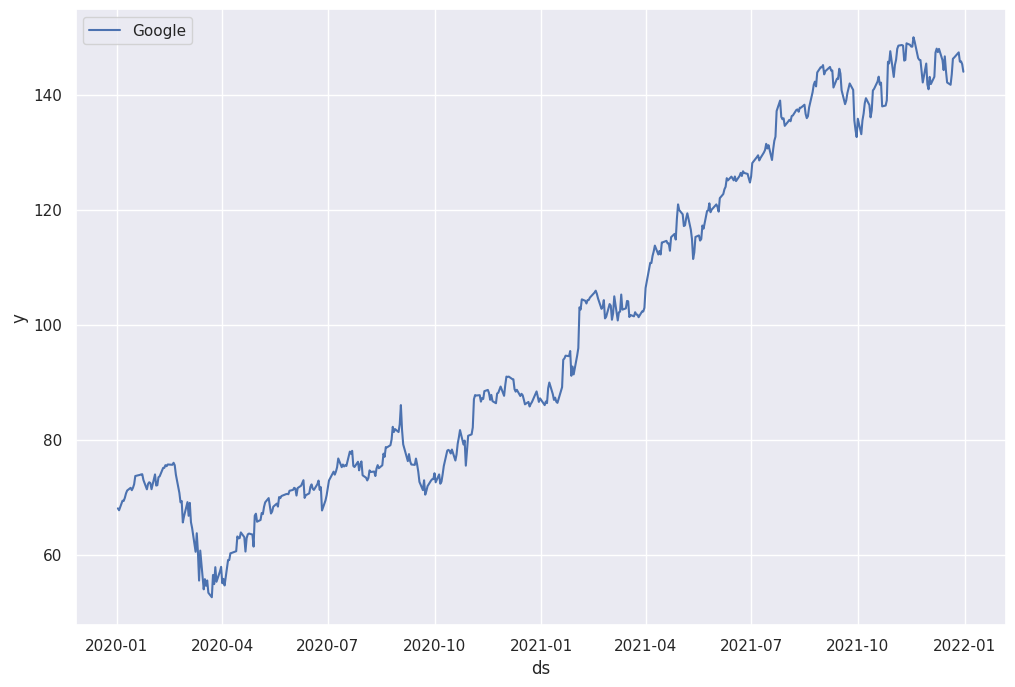

In [7]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data['ds'], y=data['y'])
plt.legend(['Google'])

# Step 3: Build Time Series Model Using Prophet in Python
In step 3, we will build a time series model using Prophet in Python.

Notice that we did not do train test split for the modeling dataset. This is because the goal of the model is not to predict future stock prices, instead, the goal is to fit a model that predicts well on the past prices. Therefore, we will use the whole dataset for both training and forecasting.

When initiating the prophet model, the yearly_seasonality and weekly_seasonality are explicitly set to True, and then fit on the training data.
The interval_width is set to 0.99, which means that the uncertainty interval is 99%.
We keep the model simple in this example to focus on the process of anomaly detection. If you are interested in building a sophisticated model, please refer to my previous tutorial Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python

In [8]:
# Add seasonality
model = Prophet(interval_width=0.99, yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwpw39os1/xhsluea7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwpw39os1/b_gm1v6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24036', 'data', 'file=/tmp/tmpwpw39os1/xhsluea7.json', 'init=/tmp/tmpwpw39os1/b_gm1v6q.json', 'output', 'file=/tmp/tmpwpw39os1/prophet_modellh1y5b41/prophet_model-20250404123853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Step 4: Make Predictions Using Prophet in Python
After building the model, in step 4, we use the model to make predictions on the dataset. The forecast plot shows that the predictions are in general aligned with the actual values.

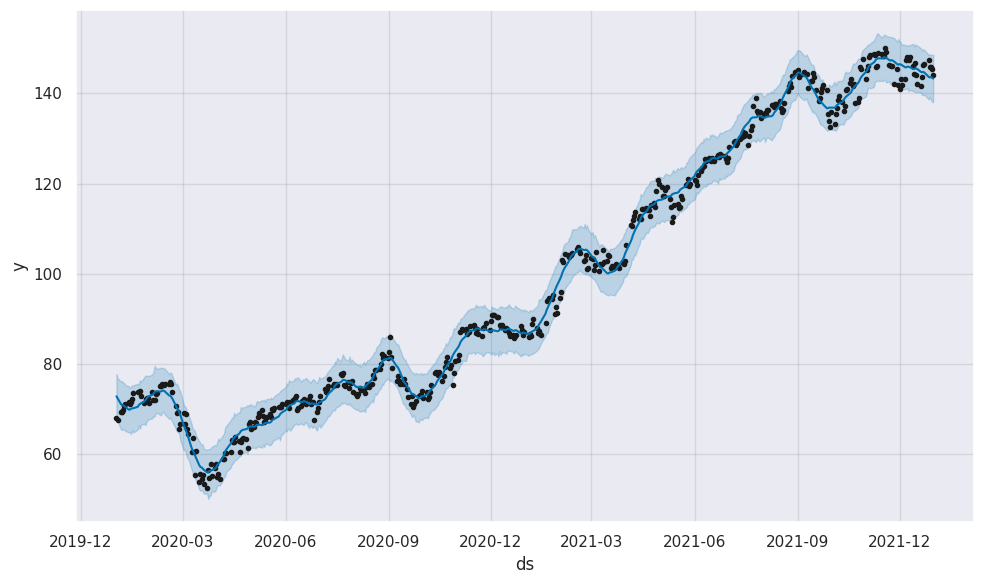

In [9]:
# Make prediction
forecast = model.predict(data)

# Visualize the forecast
model.plot(forecast); # Add semi-colon to remove the duplicated chart

We can also check the components plot for the trend, weekly seasonality, and yearly seasonality.

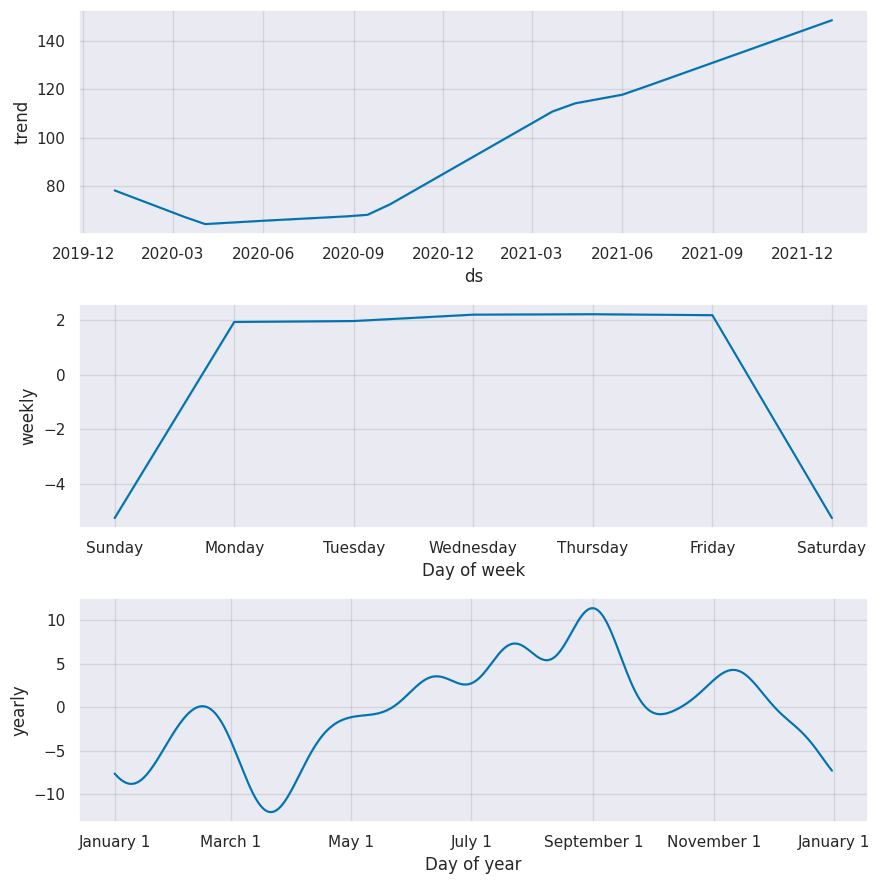

In [10]:
# Visualize the forecast components
model.plot_components(forecast);

# Step 5: Check Time Series Model Performace
In step 5, we will check the time series model performance. The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the actual dataframe to compare the actual values with the predicted values. Two performance metrics are included:

MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it’s undefined when the actual value is zero.
For more time series performance evaluation metrics such as MSE (Mean Squared Error), RMSE (Root Mean Square Error), MDAPE (Median Absolute Percentage Error), and SMAPE (Symmetric Mean Absolute Percentage Error), please refer to my previous tutorial Time Series Forecasting Of Bitcoin Prices Using Prophet



In [11]:
# Merge actual and predicted values
performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')

# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')

The MAE for the model is 1.5662200224412417
The MAPE for the model is 0.016983156994888206


# Step 6: Identify Anomalies
In step 6, we will identify the time series anomalies by checking if the actual value is outside of the uncertainty interval. If the actual value is smaller than the lower bound or larger than the upper bound of the uncertainty interval, the anomaly indicator is set to 1, otherwise, it's set to 0.

Using value_counts(), we can see that there are 6 outliers out of 505 data points.

In [12]:
# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
performance['anomaly'].value_counts()

,count
anomaly,
0,498
1,7


After printing out the anomalies, we can see that all the outliers are lower than the lower bound of the uncertainty interval.

In [13]:
# Take a look at the anomalies
anomalies = performance[performance['anomaly']==1].sort_values(by='ds')
anomalies

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
208,2020-10-28,75.473526,81.834425,77.091457,86.871360,1
269,2021-01-27,91.107964,96.153671,91.484806,101.149501,1
271,2021-01-29,91.354301,97.351737,92.493056,102.001195,1
342,2021-05-12,111.426231,117.645237,112.959052,122.584859,1
343,2021-05-13,112.565338,117.772255,112.649664,123.088754,1
480,2021-11-26,142.132782,147.093545,142.339881,152.287472,1
483,2021-12-01,140.950394,146.488277,141.375992,151.509198,1


In the visualization, all the dots are actual values and the black line represents the predicted values. The orange dots are the outliers.

<Axes: xlabel='ds', ylabel='y'>

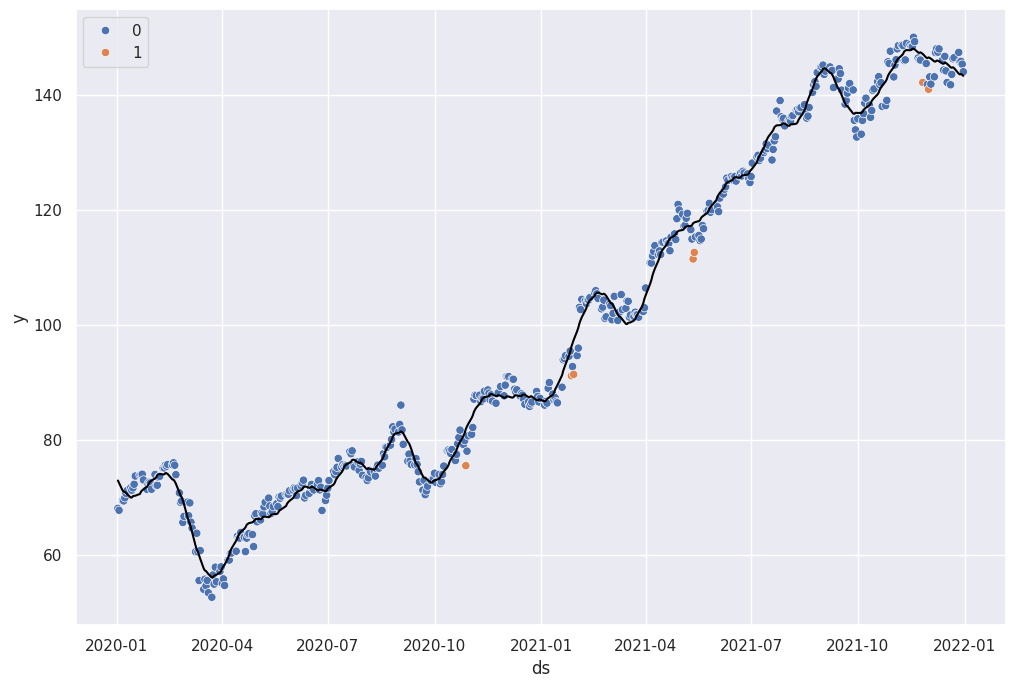

In [14]:
# Visualize the anomalies
sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=performance, color='black')